In [1]:
from os.path import expanduser
import json
from statistics import mean, stdev
import datetime as dt
import numpy as np
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

from functions.data import stationary_neighborhoods, non_stationary_neighborhoods
from functions.plotting.mpl import plot_empty
from functions.auth.connections import postgres_connection

connection_uri = postgres_connection('sf_rent_petitions')

In [2]:
save=False

# Get Data

In [3]:
query = """
SELECT date, neighborhood_number, neighborhood_name, num_petition_id
FROM petitions
;
"""
petition_df = pd_sql.read_sql(query, connection_uri, parse_dates=['date']) # grab data as a dataframe
petition_df = petition_df.reset_index(drop=True)

query = """
SELECT date, unemployment_rate
FROM unemployment
;
"""
unemployment_df = pd_sql.read_sql(query, connection_uri, parse_dates=['date']) # grab data as a dataframe
unemployment_df = unemployment_df.reset_index(drop=True)

unemployment_df['date'] = unemployment_df['date'].apply(lambda x: x-dt.timedelta(1)) # preprocessing

In [4]:
# Get counts
neighborhood_counts_df = petition_df.groupby([pd.Grouper(key="date", freq="M"), "neighborhood_name"])[
    ["neighborhood_name"]
].size().unstack().fillna(0)

# Seasonal Decompose Petitions Data

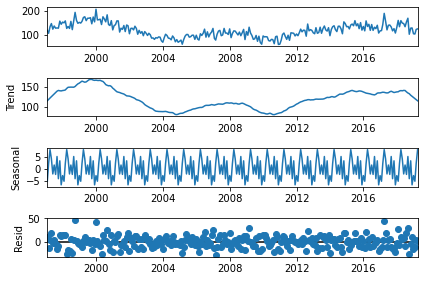

In [5]:
petition_decomp = seasonal_decompose(neighborhood_counts_df[non_stationary_neighborhoods].sum(axis=1), model='additive', extrapolate_trend = True)

# Move data into dataframe
petition_decomp_df = pd.DataFrame([petition_decomp.observed,
              petition_decomp.trend,
              petition_decomp.seasonal,
              petition_decomp.resid
             ]).T.rename(columns={'Unnamed 0': 'observed'})
petition_decomp_df['sum'] = petition_decomp_df.sum(axis=1)-petition_decomp_df['observed']
petition_decomp_df.columns = [col.capitalize() for col in petition_decomp_df.columns]
petition_decomp_df = petition_decomp_df.reset_index()

# derive additional features
seasonal_min = min(petition_decomp_df['Seasonal'])
petition_decomp_df['Adj. Trend'] = petition_decomp_df['Trend'] + seasonal_min
petition_decomp_df['Adj. Seasonal'] = petition_decomp_df['Seasonal'] - seasonal_min
petition_decomp_df['Signal'] = petition_decomp_df['Trend'] + petition_decomp_df['Resid']
petition_decomp_df['Adj. Signal'] = petition_decomp_df['Trend'] + petition_decomp_df['Resid'] + seasonal_min

petition_decomp.plot();

# Seasonal Decompose Unemployment Data

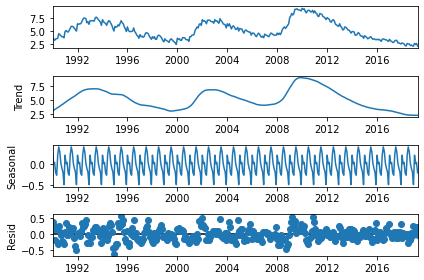

In [6]:
unemployment_decomp = seasonal_decompose(unemployment_df.set_index('date'), model='additive', extrapolate_trend = True)

# Move data into dataframe
unemployment_decomp_df = pd.DataFrame([unemployment_decomp.observed,
              unemployment_decomp.trend,
              unemployment_decomp.seasonal,
              unemployment_decomp.resid
             ]).T.rename(columns={'Unnamed 0': 'observed'})
unemployment_decomp_df['sum'] = unemployment_decomp_df.sum(axis=1)-unemployment_decomp_df['observed']
unemployment_decomp_df.columns = [col.capitalize() for col in unemployment_decomp_df.columns]
unemployment_decomp_df = unemployment_decomp_df.reset_index()

# derive additional features
seasonal_min = min(unemployment_decomp_df['Seasonal'])
unemployment_decomp_df['Adj. Trend'] = unemployment_decomp_df['Trend'] + seasonal_min
unemployment_decomp_df['Adj. Seasonal'] = unemployment_decomp_df['Seasonal'] - seasonal_min
unemployment_decomp_df['Signal'] = unemployment_decomp_df['Trend'] + unemployment_decomp_df['Resid']
unemployment_decomp_df['Adj. Signal'] = unemployment_decomp_df['Trend'] + unemployment_decomp_df['Resid'] + seasonal_min

unemployment_decomp.plot();

Text(0.5, 1.0, 'Unemployment Rate vs Petition Volume')

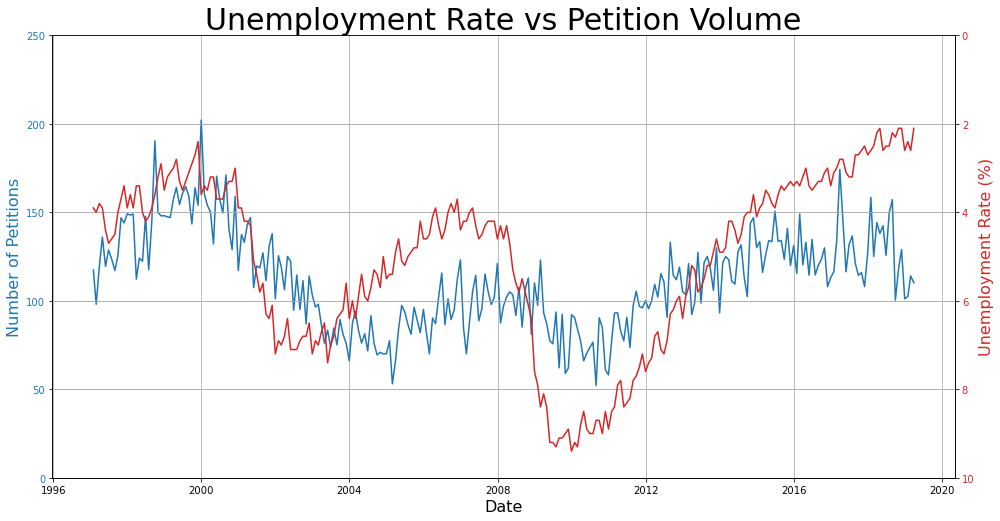

In [7]:
# Data
t = petition_decomp_df[['date', 'Adj. Signal']].rename(columns = {'Adj. Signal': 'Observed'}).set_index('date').index
data1 = petition_decomp_df[['date', 'Adj. Signal']].rename(columns = {'Adj. Signal': 'Observed'}).set_index('date').copy()
data2 = unemployment_df[unemployment_df['date'] >= min(petition_decomp_df['date'])].set_index('date').copy()

fig, ax1 = plt.subplots(figsize = (14, 7))
ax1.plot(t, data1, color='tab:blue')
ax1.set_xlabel('Date', fontsize = 16)
ax1.set_ylabel('Number of Petitions', color='tab:blue', fontsize = 16)
ax1.set_ylim(0, 250)
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(t, data2, color='tab:red')
ax2.set_ylabel('Unemployment Rate (%)', color='tab:red', fontsize = 16) 
ax2.set_ylim(10, 0)
ax2.grid(True)
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(True, axis = 'x')
plt.title('Unemployment Rate vs Petition Volume', fontsize = 30)
#plt.savefig('figures/linreg/petition-unemployment.png', transparent = True, bbox_inches = 'tight')

# Correlation vs Lag

In [8]:
# Split data
split_date = dt.datetime(2014, 1, 31)
petition_train_df = petition_decomp_df[['date', 'Adj. Signal']][petition_decomp_df['date'] <= split_date].copy()
petition_test_df = petition_decomp_df[['date', 'Adj. Signal']][petition_decomp_df['date'] > split_date].copy()

unemployment_decomp_filtered_df = unemployment_decomp_df[(unemployment_decomp_df['date'] >= min(petition_decomp_df['date']))].reset_index(drop=True)
unemployment_train_df = unemployment_decomp_filtered_df[['date', 'Adj. Signal']][unemployment_decomp_filtered_df['date'] <= split_date]
unemployment_test_df = unemployment_decomp_filtered_df[['date', 'Adj. Signal']][unemployment_decomp_filtered_df['date'] > split_date]

In [9]:
# Unemployment Autocorrelation
corr_list = []
for i in range(0, 13):
    corr_list.append(
        np.corrcoef(
            unemployment_train_df['Adj. Signal'].shift(i).iloc[i:len(unemployment_train_df)],
            petition_train_df['Adj. Signal'].iloc[i:len(petition_train_df)]
        )[0][1]
    )
corr_list

[-0.6221860937175573,
 -0.6337344623647252,
 -0.6434687892442368,
 -0.6495941214576078,
 -0.6469817924029261,
 -0.6507449191955986,
 -0.6508471733746759,
 -0.6456352462160282,
 -0.6450240378685412,
 -0.640857324000304,
 -0.6281411504554443,
 -0.6195165724963749,
 -0.6078770962213916]

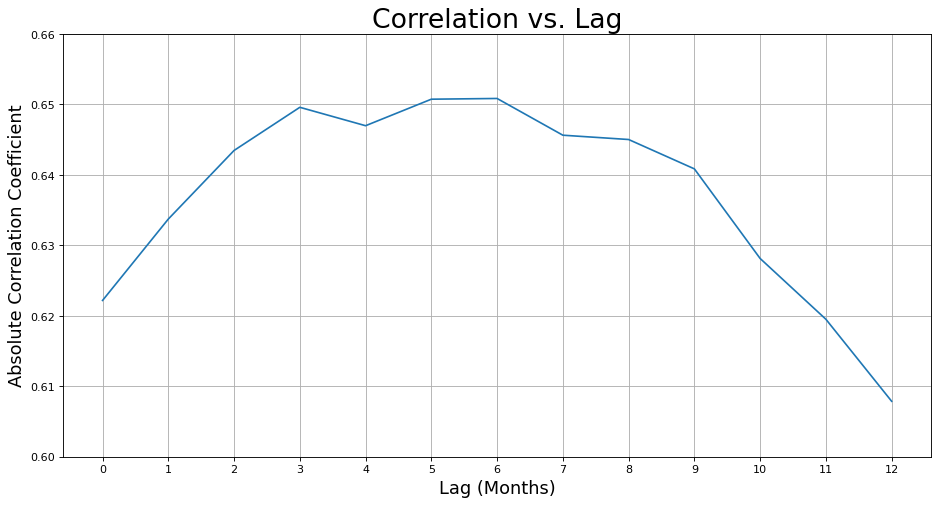

In [10]:
fig, ax = plot_empty(xlabel='Lag (Months)', ylabel='Absolute Correlation Coefficient', title='Correlation vs. Lag',
                     figsize=(14, 7))
plt.plot([abs(corr) for corr in corr_list])
plt.xticks(range(0, 13))
plt.ylim(0.6, 0.66)
ax.grid(True)
if save:
    plt.savefig('figures/linreg/correlation-vs-lag', transparent = True, bbox_inches="tight")

# Linear Regression on 3-Month Lag

In [11]:
num_months = 3
data_df = pd.DataFrame(unemployment_train_df['Adj. Signal'].shift(num_months).iloc[num_months:len(unemployment_train_df)])
data_df = data_df.rename(columns = {'Adj. Signal': 'Unemployment'})
data_df['Petition'] = petition_train_df['Adj. Signal'].iloc[num_months:len(unemployment_train_df)]

In [12]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 72)
scaler = StandardScaler()

# Scikit Learn's LinearRegression with Log Variables

# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(data_df.drop(columns = ['Petition']), data_df['Petition'], test_size=.2, random_state=42)

# Choose features, KFold requires ndarray inputs
features_list = ['Unemployment']

features_train_chosen_df = features_train_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
features_test_chosen_df = features_test_all_df[features_list]
features_test_chosen_array = np.array(features_test_chosen_df)
target_train_array = np.array(target_train_ser)
target_test_array = np.array(target_test_ser)

# KFold Cross-Validation
r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    #features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)  # Scale resampled features
    #features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_array))
    ols_results = ols_model.fit() # Fit model
    
    # Collect results on the validation set
    SSE = sum((target_val_cv_array - ols_results.predict(sm.add_constant(features_val_cv_array)))**2)
    SST = sum((target_val_cv_array - np.mean(target_val_cv_array))**2)
    r2_cv_list.append(1-SSE/SST)

print(r2_cv_list)
print('train_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))

# Test
#features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
#features_test_scaled_array = scaler.transform(features_test_chosen_df)

# Fit model
ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_chosen_df))
ols_results = ols_model.fit()

# Save results for comparison later
OLS_array = ols_results.predict(sm.add_constant(features_test_chosen_df))

# Collect results on the test set
SSE = sum((target_test_ser - OLS_array)**2)
SST = sum((target_test_ser - np.mean(target_test_ser))**2)

print('test_r2_score: ', 1-SSE/SST) #Get score
print(list(ols_results.params[0:2]))

[0.31359405807831553, 0.4399256592772216, 0.4568542834556224, 0.2740424906175716, 0.47431237332320986]
train_r2_score:  0.3917457729503882  +/-  0.09129542197334774
test_r2_score:  0.38210239662727863
[161.235465022328, -10.588352665778231]


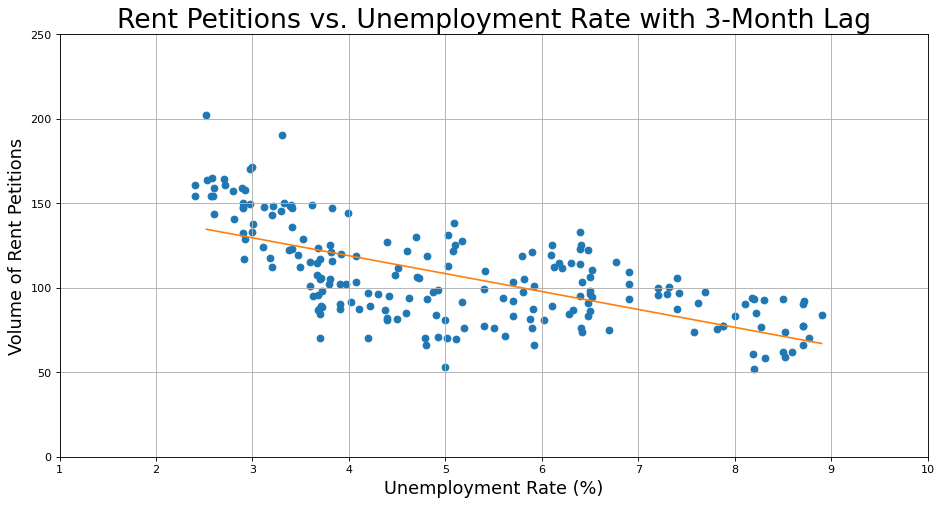

In [13]:
# Plot
line = [min(features_test_chosen_df.Unemployment), max(features_train_chosen_df.Unemployment)]
fig, ax = plot_empty(xlabel='Unemployment Rate (%)', ylabel='Volume of Rent Petitions',
                     title=f'Rent Petitions vs. Unemployment Rate with {num_months}-Month Lag',
                     figsize=(14, 7))
plt.scatter(features_test_chosen_df, target_test_ser, color = '#1f77b4', label = None)
plt.scatter(features_train_chosen_df, target_train_ser, color = '#1f77b4', label = None)
plt.plot(line, ols_results.predict(sm.add_constant(line)), color = '#ff7f0e', label = "Fit")
plt.xlim(1, 10)
plt.ylim(0, 250)
plt.grid(True)

if save:
    plt.savefig(f"figures/linreg/linreg-{num_months}-months.png", transparent=True, bbox_inches="tight")

# Forecast on 3-Month Lag

In [14]:
# Generating Predictions based on OLS
prediction_df = petition_decomp_df[['date', 'Adj. Signal']].copy()
prediction_df['Predict'] = unemployment_decomp_filtered_df['Observed'] \
    .apply(lambda x: ols_results.params[0:2][0] + x * ols_results.params[0:2][1]).round().shift(3) \
    + petition_decomp_df['Adj. Seasonal']

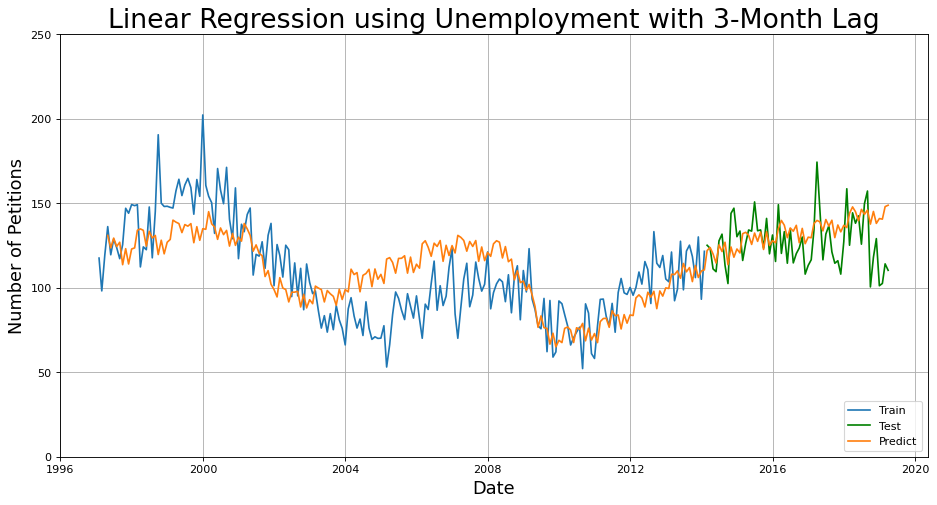

In [15]:
# Plot
fig, ax = plot_empty(ylabel='Number of Petitions', title=f'Linear Regression using Unemployment with {num_months}-Month Lag',
                     figsize=(14, 7))
plt.plot(petition_train_df[['date', 'Adj. Signal']].set_index('date'), label = 'Train')
plt.plot(petition_test_df[['date', 'Adj. Signal']].set_index('date'), label = 'Test', color = 'g')
plt.plot(prediction_df[['date', 'Predict']].set_index('date'), label = 'Predict')
plt.xlabel('Date')
plt.ylim(0, 250)
plt.legend(loc = 'lower right')
ax.grid(True)
if save:
    plt.savefig(f"figures/linreg/predicted-{num_months}-month-lag.png", transparent=True, bbox_inches="tight")

In [16]:
# MAE for 3 months
mean(abs(
    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 4, 30))]['Adj. Signal']
     -    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 4, 30))]['Predict']) )
    ))

4.145750988142301

In [17]:
# MAE for 3 months
mean(abs(
    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 12, 31))]['Adj. Signal']
     -    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 12, 31))]['Predict']) )
    ))

10.115852197868008

In [18]:
# MAE for 5 years
mean(abs(
    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))]['Adj. Signal']
     -    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))]['Predict']) )
    ))

13.452231820306864

# Linear Regression on 5-Month Lag

In [19]:
num_months = 5
data_df = pd.DataFrame(unemployment_train_df['Adj. Signal'].shift(num_months).iloc[num_months:len(unemployment_train_df)])
data_df = data_df.rename(columns = {'Adj. Signal': 'Unemployment'})
data_df['Petition'] = petition_train_df['Adj. Signal'].iloc[num_months:len(unemployment_train_df)]

In [20]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 72)
scaler = StandardScaler()

# Scikit Learn's LinearRegression with Log Variables

# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(data_df.drop(columns = ['Petition']), data_df['Petition'], test_size=.2, random_state=42)

# Choose features, KFold requires ndarray inputs
features_list = ['Unemployment']

features_train_chosen_df = features_train_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
features_test_chosen_df = features_test_all_df[features_list]
features_test_chosen_array = np.array(features_test_chosen_df)
target_train_array = np.array(target_train_ser)
target_test_array = np.array(target_test_ser)

# KFold Cross-Validation
r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    #features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)  # Scale resampled features
    #features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_array))
    ols_results = ols_model.fit() # Fit model
    
    # Collect results on the validation set
    SSE = sum((target_val_cv_array - ols_results.predict(sm.add_constant(features_val_cv_array)))**2)
    SST = sum((target_val_cv_array - np.mean(target_val_cv_array))**2)
    r2_cv_list.append(1-SSE/SST)

print(r2_cv_list)
print('train_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))

# Test
#features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
#features_test_scaled_array = scaler.transform(features_test_chosen_df)

# Fit model
ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_chosen_df))
ols_results = ols_model.fit()

# Save results for comparison later
OLS_array = ols_results.predict(sm.add_constant(features_test_chosen_df))

# Collect results on the test set
SSE = sum((target_test_ser - OLS_array)**2)
SST = sum((target_test_ser - np.mean(target_test_ser))**2)

print('test_r2_score: ', 1-SSE/SST) #Get score
print(list(ols_results.params[0:2]))

[0.33971840737195225, 0.3927695824990739, 0.29771270448238185, 0.5302516764135781, 0.44381997559817177]
train_r2_score:  0.4008544692730316  +/-  0.09087199658393007
test_r2_score:  0.2761706052956986
[161.19201639747894, -10.587846841810581]


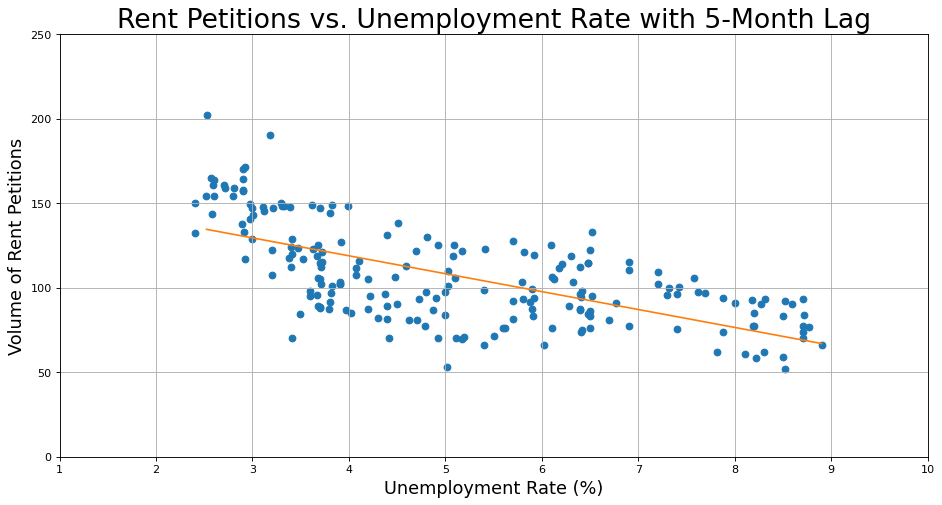

In [21]:
# Plot
line = [min(features_test_chosen_df.Unemployment), max(features_train_chosen_df.Unemployment)]

fig, ax = plot_empty(xlabel='Unemployment Rate (%)', ylabel='Volume of Rent Petitions',
                     title=f'Rent Petitions vs. Unemployment Rate with {num_months}-Month Lag',
                     figsize=(14, 7))
plt.scatter(features_test_chosen_df, target_test_ser, color = '#1f77b4', label = None)
plt.scatter(features_train_chosen_df, target_train_ser, color = '#1f77b4', label = None)
plt.plot(line, ols_results.predict(sm.add_constant(line)), color = '#ff7f0e', label = "Fit")
plt.xlim(1, 10)
plt.ylim(0, 250)
plt.grid(True)

if save:
    plt.savefig(f"figures/linreg/linreg-{num_months}-months.png", transparent=True, bbox_inches="tight")

# Forecast on 5-Month Lag

In [22]:
# Generating Predictions based on OLS
prediction_df = petition_decomp_df[['date', 'Adj. Signal']].copy()
prediction_df['Predict'] = unemployment_decomp_filtered_df['Observed'] \
    .apply(lambda x: ols_results.params[0:2][0] + x * ols_results.params[0:2][1]).round().shift(5) \
    + petition_decomp_df['Adj. Seasonal']

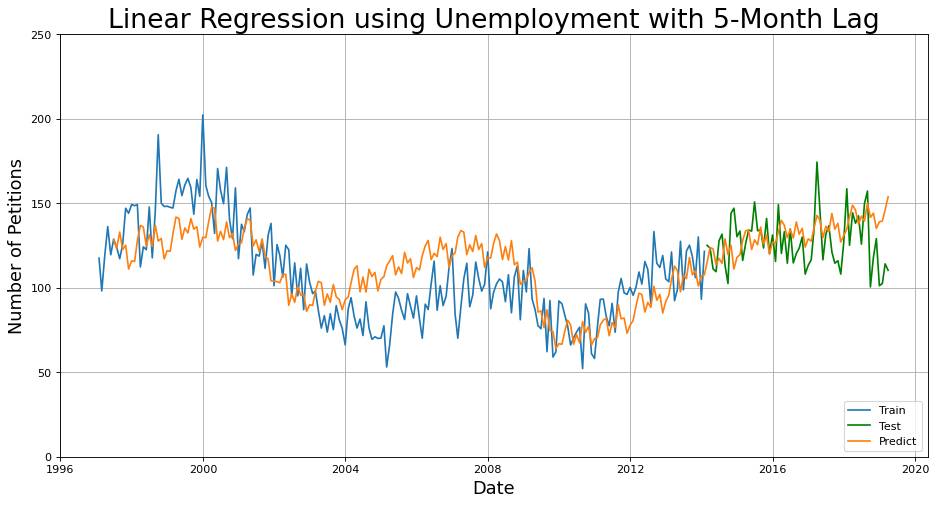

In [23]:
# Plot
fig, ax = plot_empty(ylabel='Number of Petitions', title=f'Linear Regression using Unemployment with {num_months}-Month Lag',
                     figsize=(14, 7))
plt.plot(petition_train_df[['date', 'Adj. Signal']].set_index('date'), label = 'Train')
plt.plot(petition_test_df[['date', 'Adj. Signal']].set_index('date'), label = 'Test', color = 'g')
plt.plot(prediction_df[['date', 'Predict']].set_index('date'), label = 'Predict')

plt.xlabel('Date')
plt.ylim(0, 250)
plt.legend(loc = 'lower right')
ax.grid(True)
if save:
    plt.savefig(f"figures/linreg/predicted-{num_months}-month-lag.png", transparent=True, bbox_inches="tight")

In [24]:
# MAE for 3 months
mean(abs(
    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 4, 30))]['Adj. Signal']
     -    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 4, 30))]['Predict']) )
    ))

7.479084321475635

In [25]:
# MAE for 3 months
mean(abs(
    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 12, 31))]['Adj. Signal']
     -    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 12, 31))]['Predict']) )
    ))

14.024943106958917

In [26]:
# MAE for 5 years
mean(abs(
    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))]['Adj. Signal']
     -    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))]['Predict']) )
    ))

13.961396043180763

# Linear Regression on 6-Month Lag

In [27]:
num_months = 6
data_df = pd.DataFrame(unemployment_train_df['Adj. Signal'].shift(num_months).iloc[num_months:len(unemployment_train_df)])
data_df = data_df.rename(columns = {'Adj. Signal': 'Unemployment'})
data_df['Petition'] = petition_train_df['Adj. Signal'].iloc[num_months:len(unemployment_train_df)]

In [28]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 72)
scaler = StandardScaler()

# Scikit Learn's LinearRegression with Log Variables

# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(data_df.drop(columns = ['Petition']), data_df['Petition'], test_size=.2, random_state=42)

# Choose features, KFold requires ndarray inputs
features_list = ['Unemployment']

features_train_chosen_df = features_train_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
features_test_chosen_df = features_test_all_df[features_list]
features_test_chosen_array = np.array(features_test_chosen_df)
target_train_array = np.array(target_train_ser)
target_test_array = np.array(target_test_ser)

# KFold Cross-Validation
r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    #features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)  # Scale resampled features
    #features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_array))
    ols_results = ols_model.fit() # Fit model
    
    # Collect results on the validation set
    SSE = sum((target_val_cv_array - ols_results.predict(sm.add_constant(features_val_cv_array)))**2)
    SST = sum((target_val_cv_array - np.mean(target_val_cv_array))**2)
    r2_cv_list.append(1-SSE/SST)

print(r2_cv_list)
print('train_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))

# Test
#features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
#features_test_scaled_array = scaler.transform(features_test_chosen_df)

# Fit model
ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_chosen_df))
ols_results = ols_model.fit()

# Save results for comparison later
OLS_array = ols_results.predict(sm.add_constant(features_test_chosen_df))

# Collect results on the test set
SSE = sum((target_test_ser - OLS_array)**2)
SST = sum((target_test_ser - np.mean(target_test_ser))**2)

print('test_r2_score: ', 1-SSE/SST) #Get score
print(list(ols_results.params[0:2]))

[0.15518711597842472, 0.471452303051902, 0.2722154516166436, 0.5301198866540996, 0.3783362989513064]
train_r2_score:  0.3614622112504753  +/-  0.1511144976809045
test_r2_score:  0.3299068233430954
[161.6942514223681, -10.594172579452984]


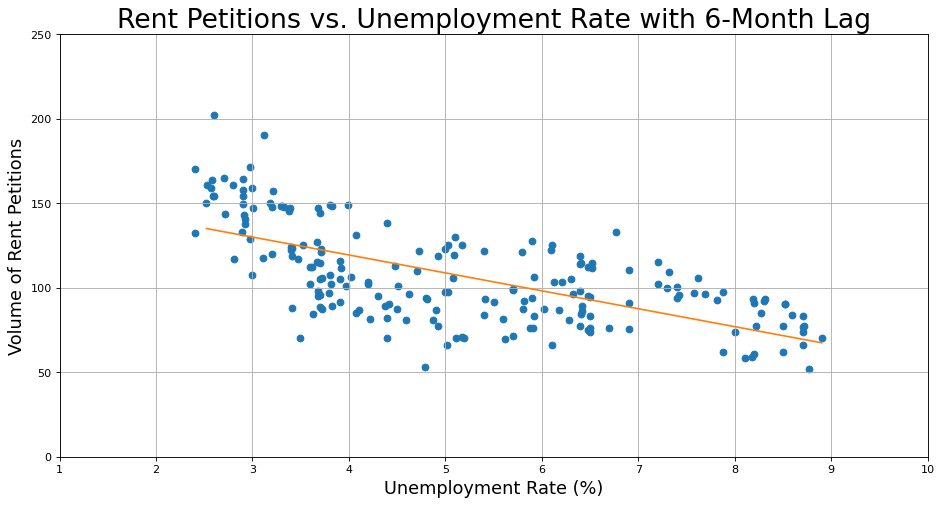

In [29]:
# Plot
line = [min(features_test_chosen_df.Unemployment), max(features_train_chosen_df.Unemployment)]
fig, ax = plot_empty(xlabel='Unemployment Rate (%)', ylabel='Volume of Rent Petitions',
                     title=f'Rent Petitions vs. Unemployment Rate with {num_months}-Month Lag',
                     figsize=(14, 7))
plt.scatter(features_test_chosen_df, target_test_ser, color = '#1f77b4', label = None)
plt.scatter(features_train_chosen_df, target_train_ser, color = '#1f77b4', label = None)
plt.plot(line, ols_results.predict(sm.add_constant(line)), color = '#ff7f0e', label = "Fit")
plt.xlim(1, 10)
plt.ylim(0, 250)
plt.grid(True)

if save:
    plt.savefig(f"figures/linreg/linreg-{num_months}-months.png", transparent=True, bbox_inches="tight")

# Forecast on 6-Month Lag

In [30]:
# Generating Predictions based on OLS
prediction_df = petition_decomp_df[['date', 'Adj. Signal']].copy()
prediction_df['Predict'] = unemployment_decomp_filtered_df['Observed'] \
    .apply(lambda x: ols_results.params[0:2][0] + x * ols_results.params[0:2][1]).round().shift(6) \
    + petition_decomp_df['Adj. Seasonal']

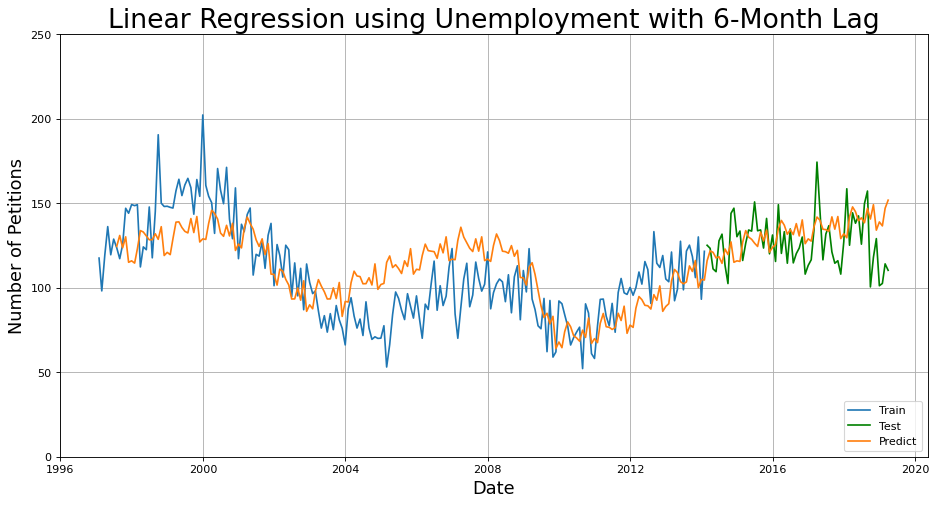

In [31]:
# Plot
fig, ax = plot_empty(ylabel='Number of Petitions', title=f'Linear Regression using Unemployment with {num_months}-Month Lag',
                     figsize=(14, 7))
plt.plot(petition_train_df[['date', 'Adj. Signal']].set_index('date'), label = 'Train')
plt.plot(petition_test_df[['date', 'Adj. Signal']].set_index('date'), label = 'Test', color = 'g')
plt.plot(prediction_df[['date', 'Predict']].set_index('date'), label = 'Predict')

plt.xlabel('Date')
plt.ylim(0, 250)
plt.legend(loc = 'lower right')
ax.grid(True)
if save:
    plt.savefig(f"figures/linreg/predicted-{num_months}-month-lag.png", transparent=True, bbox_inches="tight")

In [32]:
# MAE for 3 months
mean(abs(
    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 4, 30))]['Adj. Signal']
     -    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 4, 30))]['Predict']) )
    ))

6.820212999560766

In [33]:
# MAE for 3 months
mean(abs(
    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 12, 31))]['Adj. Signal']
     -    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))
              & (prediction_df['date'] <= dt.datetime(2014, 12, 31))]['Predict']) )
    ))

13.208887291891227

In [34]:
# MAE for 5 years
mean(abs(
    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))]['Adj. Signal']
     -    (prediction_df[(prediction_df['date'] > dt.datetime(2014, 1, 31))]['Predict']) )
    ))

14.228757597007952